# Preprocessing of the data
1) Download the stock data<br>
2) Calculate the returns on a 5 days period<br>
3) Fill missing values for factors & analyzing timeframes for instruments<br>

In [21]:
import urllib.request as url
import pandas as pd 
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt

In [22]:
#%% Import dataframes

instrumentsReturns = pd.read_csv("https://raw.githubusercontent.com/ie-mcsbt-team-c/VaR_Spark/master/instruments_returns.csv")
instrumentsReturns = pd.DataFrame(instrumentsReturns)

factors_with_dates =  pd.read_csv("https://raw.githubusercontent.com/ie-mcsbt-team-c/VaR_Spark/master/factors_returns.csv")
factors_with_dates = pd.DataFrame(factors_with_dates)

factorsReturns = pd.read_csv("https://raw.githubusercontent.com/ie-mcsbt-team-c/VaR_Spark/master/factors_returns.csv")
factorsReturns = pd.DataFrame(factorsReturns)

factorsReturns["Date"] = pd.to_datetime(factorsReturns["Date"])
factors_with_dates["Date"] = pd.to_datetime(factors_with_dates["Date"])
instrumentsReturns["Date"] = pd.to_datetime(instrumentsReturns["Date"])

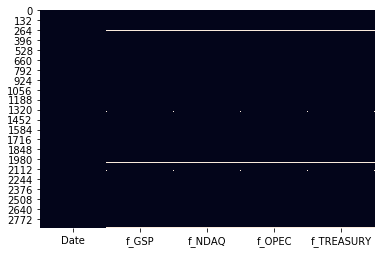

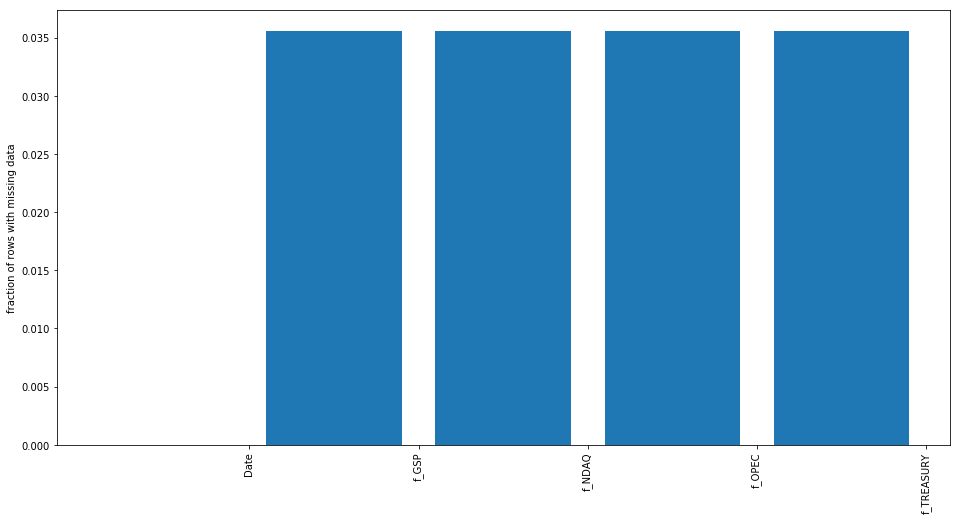

In [23]:
#%% Visualize null-values for Factors

# Assess the number of null values

factorsReturns.isnull().sum()

# The heat map show correlated null-values across the data - meaning that all factors have null-values on the same dates. 
# It can be assumed that these dates are official hollidays, that apply to all factors.
sbn.heatmap(factorsReturns.isnull(), cbar=False)

#All columns have the same number of null values (103)
null_counts = factorsReturns.isnull().sum()/len(factorsReturns)
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
plt.ylabel('fraction of rows with missing data')
plt.bar(np.arange(len(null_counts)),null_counts)


# Df with all rows containing null values including the date (103 entries)
# We can see that each year has around 9-10 dates with null-values spread across the month.
# Therefore filling null values with the proceeding value can be an adequate method to deal with them. 
null_data = factorsReturns[factorsReturns.isnull().any(axis=1)]

In [24]:
#%% Filling null values for Factors

factorsReturns = factorsReturns.fillna(method='bfill')
factorsReturns = factorsReturns.fillna(method='ffill')

#careful null values fill should be done individually for each instrument and trim out the 
#inexsting dates, and before the returns are calculated..

# Running the model on each instrument

1) Featurization : generate 3 features for each one of the 4 factors<br>
2) Align timeframes of factors with the specific instrument<br>
3) Run a linear regression based on features on a specific instrument & generate parameters


Featurization : generate 3 features for each one of the 4 factors

In [25]:
#%%
#Featurization of the factors

#Creation of a matrix of factors
Dates = pd.DataFrame(factorsReturns["Date"])
F1 = np.array(factorsReturns["f_GSP"])
F2 = np.array(factorsReturns["f_NDAQ"])
F3 = np.array(factorsReturns["f_OPEC"])
F4 = np.array(factorsReturns["f_TREASURY"])
factorsReturns = list((F1,F2,F3,F4))

def transpose(matrix):
    return [[matrix[j][i] for j in range(len(matrix))] for i in range(len(matrix[0]))]

def get_features(factorReturns):
    factorReturns = list(factorReturns)
    squaredReturns = [np.sign(element)*(element)**2 for element in factorReturns]
    squareRootedReturns = [np.sign(element)*abs(element)**0.5 for element in factorReturns]
    # concat new features
    return squaredReturns + squareRootedReturns + factorReturns

# transpose factorsReturns
factorMat = transpose(factorsReturns)

# featurize each row of factorMat
factorFeatures = list(map(get_features,factorMat))

Dates = pd.DataFrame(factors_with_dates["Date"])
F = pd.DataFrame(factorFeatures)

F = pd.merge(F,Dates, left_index = True, right_index = True)

F.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,Date
0,-0.000045,0.001138,0.001138,0.001138,-0.082019,0.183660,0.183660,0.183660,-0.006727,0.033731,0.033731,0.033731,2019-01-31
1,-0.000008,0.001462,0.001462,0.001462,-0.052902,0.195548,0.195548,0.195548,-0.002799,0.038239,0.038239,0.038239,2019-01-30
2,0.000452,0.001091,0.001091,0.001091,0.145817,0.181747,0.181747,0.181747,0.021263,0.033032,0.033032,0.033032,2019-01-29
3,0.000111,0.001945,0.001945,0.001945,0.102703,0.210008,0.210008,0.210008,0.010548,0.044103,0.044103,0.044103,2019-01-28
4,0.000430,0.002957,0.002957,0.002957,0.143994,0.233196,0.233196,0.233196,0.020734,0.054380,0.054380,0.054380,2019-01-25


Align timeframes of factors with the specific instrument

<BarContainer object of 42 artists>

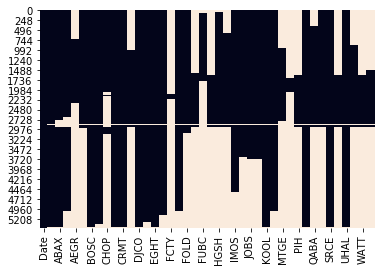

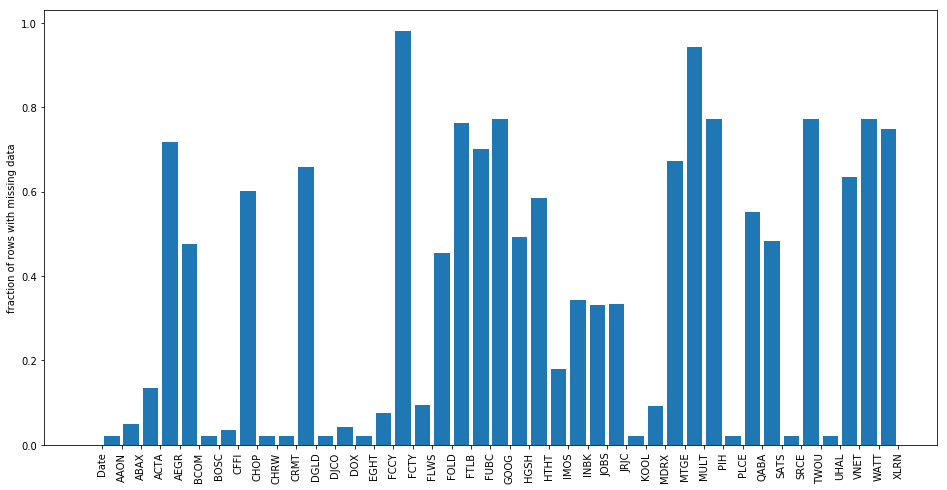

In [26]:
#%% Visualize null-values for Instruments

# Assess the number of null values

instrumentsReturns.isnull().sum()

# The heat map show correlated null-values across the data - meaning that all factors have null-values on the same dates. 
# It can be assumed that these dates are official hollidays, that apply to all factors.
sbn.heatmap(instrumentsReturns.isnull(), cbar=False)

# Number of null values accross instruments varies a lot. It would not be appropriate
# to fill based on the same strategy as the factors, therefore we will align the factors
# to run a model based on the available timeframe for each instrument
null_counts = instrumentsReturns.isnull().sum()/len(instrumentsReturns)
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
plt.ylabel('fraction of rows with missing data')
plt.bar(np.arange(len(null_counts)),null_counts)

In [27]:
#%% This align_dates function will be used to adapt the featuresReturns to 
# the available timeframe of each instrument

def align_dates(ins):
    
    A = instrumentsReturns[["Date",ins]]
    A = A.dropna()
    B = F
    
    X = pd.merge(A,B,on="Date")
    return X

# testing the function with one instrument
align_dates("SRCE")


,Date,SRCE,0,1,2,3,4,5,6,7,8,9,10,11
0,2008-02-01,-0.083008,0.000230,0.002391,0.002391,0.002391,0.123100,0.221134,0.221134,0.221134,0.015154,0.048900,0.048900,0.048900
1,2008-03-01,-0.131482,0.000012,0.000291,0.000291,0.000291,0.059443,0.130603,0.130603,0.130603,0.003533,0.017057,0.017057,0.017057
2,2008-04-01,-0.098999,-0.000634,-0.000286,-0.000286,-0.000286,-0.158701,-0.130069,-0.130069,-0.130069,-0.025186,-0.016918,-0.016918,-0.016918
3,2008-07-01,-0.000583,-0.001029,-0.001490,-0.001490,-0.001490,-0.179102,-0.196454,-0.196454,-0.196454,-0.032078,-0.038594,-0.038594,-0.038594
4,2008-08-01,-0.092388,-0.003113,-0.011454,-0.011454,-0.011454,-0.236215,-0.327141,-0.327141,-0.327141,-0.055797,-0.107021,-0.107021,-0.107021
5,2008-09-01,0.015700,-0.001850,-0.004081,-0.004081,-0.004081,-0.207392,-0.252758,-0.252758,-0.252758,-0.043012,-0.063887,-0.063887,-0.063887
6,2008-10-01,0.033639,-0.003324,-0.014381,-0.014381,-0.014381,-0.240121,-0.346293,-0.346293,-0.346293,-0.057658,-0.119919,-0.119919,-0.119919
7,2008-11-01,-0.020233,-0.001607,-0.010161,-0.010161,-0.010161,-0.200206,-0.317495,-0.317495,-0.317495,-0.040083,-0.100803,-0.100803,-0.100803
8,2008-01-14,-0.034342,-0.000354,-0.001974,-0.001974,-0.001974,-0.137128,-0.210797,-0.210797,-0.210797,-0.018804,-0.044435,-0.044435,-0.044435
9,2008-01-15,0.028296,-0.000886,-0.000078,-0.000078,-0.000078,-0.172544,-0.093890,-0.093890,-0.093890,-0.029771,-0.008815,-0.008815,-0.008815


Run a linear regression based on 12 features on a specific instrument & generate parameters

In [8]:
#%%
#Training a linear regression model with our 4 features for each instrument and saving
# the coefficients and intercepts in lists to reuse later

from sklearn.linear_model import LinearRegression

def get_params(ins):
    
    X = align_dates(ins).drop(columns=["Date",ins],axis=0)
    y = align_dates(ins)[ins]
    
    lm= LinearRegression()

    lm.fit(X,y)
    coef = lm.coef_
    inter = lm.intercept_

    params = [coef,inter]
    return params


# testing the function with one instrument
get_params("SRCE")

[array([-0.63299677, -0.01426872, -0.01426872, -0.01426872, -0.01033641,
         0.0107016 ,  0.0107016 ,  0.0107016 ,  0.19371338,  0.01777795,
         0.01777795,  0.01777795]), 0.0019315007169335451]

# Generating random samples of factors

1) Generate random sample using a multivariate normal distribution & featurize <br>
2) Get the return for each instrument and the total trial portfolio


In [56]:
#%%
# Generating a random multivariate sample
#
##We could sample each factor independently but, in that case, we will be ignoring the
##correlation among the four factors. 
##We will use a multivariate normal distribution. To get sample values we just we can just use 
## numpy like this:
##f1, f2, f3, f4 = numpy.random.multivariate_normal(mean, cov)

instruments = ["PIH", "FLWS", "FCTY", "FCCY", "SRCE",
               "FUBC","VNET","TWOU","DGLD","JOBS"
               ,"EGHT","AAON","ABAX","XLRN","ACTA"
               ,"MULT","AEGR","MDRX","DOX"
               ,"UHAL","MTGE","CRMT","FOLD","BCOM"
               ,"BOSC","CFFI","CHRW","KOOL"
               ,"PLCE","JRJC","CHOP","HGSH"
               ,"HTHT","IMOS","DJCO","SATS"
               ,"WATT","INBK","FTLB","QABA","GOOG"]

factorsReturns_list = list((F1,F2,F3,F4))

cov = np.cov(factorsReturns_list)
mean = list((F1.mean(axis=0),F2.mean(axis=0),F3.mean(axis=0),F4.mean(axis=0)))

sample = np.random.multivariate_normal(mean, cov)

print("This is the covariance table")
print(cov)
print("This is the mean")
print(mean)
print("This is a sample set of factors")
print(sample)

This is the covariance table
[[0.00071065 0.0008703  0.0008703  0.0008703 ]
 [0.0008703  0.00261676 0.00261676 0.00261676]
 [0.0008703  0.00261676 0.00261676 0.00261676]
 [0.0008703  0.00261676 0.00261676 0.00261676]]
This is the mean
[0.001533030559626685, 0.002620320030418251, 0.002620320030418251, 0.002620320030418251]
This is a sample set of factors
[-0.00293636 -0.00733837 -0.00733837 -0.00733837]


In [63]:
#Approach in python to generate trials and store the returns in a list

def generate_trial(t,mean,cov):
    
    #creating an empty list to store the returns   
    trialReturns = []
    
    #creating a loop to go over t number of trials
    for i in range(0, t):
    
    #initializing the total portfolio return
        trial_portfolioReturn = 0
        
    #generating one sample of 4 factors
        trial_factorReturns = np.random.multivariate_normal(mean, cov)
        
    #featurizing sampled factors into 12 features
        trial_featuresReturns = get_features(trial_factorReturns)          

    #creating a loop to generate return of 1 instrument  
        for ins in instruments:       
            
    #run linear model for specific instrument and applying coefs + intercept on the 
    #sampled features to get sampled return     
            trial_instrumentReturn = sum((get_params(ins)[0] * trial_featuresReturns) + get_params(ins)[1])        
            trial_portfolioReturn += trial_instrumentReturn*(1/(len(instruments))) 
            
        trialReturns.append(trial_portfolioReturn)
        
    return trialReturns

test = generate_trial(20,mean,cov)
print(test)

[0.036311548518722495, 0.024397838587663968, 0.036894888593039486, 0.03545689263394775, 0.020453839460646862, 0.04349886856731593, 0.0411637393221822, 0.0338017429255475, 0.05478498169204006, 0.06693726106665741, 0.03259219360452208, 0.041206336511169485, 0.03786358098849372, 0.0404968279299237, 0.042738008069929244, 0.021719599440049035, 0.024344844384183238, 0.04323374103402641, 0.01948838624373832, 0.03288339049418272]


Calculation of the VaR based on the generated trials

In [62]:
def fivePercentVaR(trials):
    numTrials = len(trials)

    fivePercent = max(round(numTrials/20.0), 1)

    trials.sort()

    fivePercentWorst = trials[0:fivePercent]
    return fivePercentWorst[-1]

fivePercentVaR(test)

0.02594553024047342

# Adapting the approach for Spark

For simplicity purposes we will rewrite the generate_trials function in order 
to take the coefficients and intercepts from csv files instead of generating them
inside of the function

In [64]:

#First we need to create csv files containing the coefficients and intercepts

coef = []
inter = []

for ins in instruments:
    
    coef.append(get_params(ins)[0])
    inter.append(get_params(ins)[1])

coefs = pd.DataFrame(coef)    
export_csv = coefs.to_csv(r"C:\Users\Leila\Desktop\VaR_Spark\coefs.csv", index = None, header=False)

inter = pd.DataFrame(inter)    
export_csv = inter.to_csv(r"C:\Users\Leila\Desktop\VaR_Spark\inter.csv", index = None, header=False)  

#We need to create csv with cov and mean 

cov = np.cov(factorsReturns_list)
cov = pd.DataFrame(cov)
export_csv = cov.to_csv(r"C:\Users\Leila\Desktop\VaR_Spark\cov.csv", index = None, header=False) 

mean = list((F1.mean(axis=0),F2.mean(axis=0),F3.mean(axis=0),F4.mean(axis=0)))
mean = pd.DataFrame(mean)
export_csv = mean.to_csv(r"C:\Users\Leila\Desktop\VaR_Spark\mean.csv", index = None, header=False)

#Now we need to modify our generate_trials function in order to use the params 
#from the csv files



In [12]:
def generate_trial(t,mean,cov,coefs,inter):
    
    #creating an empty list to store the returns
    
    trialReturns = []
    
    #creating a loop to go over t number of trials

    for i in range(0, t): 
         
    #initializing the total portfolio return
            
            trial_portfolioReturn = 0
            
    #generating one sample of 4 factors
            
            trial_factorReturns = np.random.multivariate_normal(mean, cov)
            
    #featurizing sampled factors into 12 features
    
            trial_featuresReturns = get_features(trial_factorReturns)
            
    #run linear model for specific instrument and applying coefs + intercept on the 
    #sampled features to get sampled return
            
            for k in range(len(coefs)):
            
                trial_instrumentReturn = sum([coefs[k][i] * trial_featuresReturns[i] for i in range(len(trial_featuresReturns))]) + inter[k]
    
            trial_portfolioReturn += trial_instrumentReturn
        
            trialReturns.append(trial_portfolioReturn)
    
    return trialReturns

parallelism = 2
t = 10000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)

trials = seedRDD.flatMap(lambda idx: \
                generate_trial(
                    max(int(t/parallelism), 1), 
                    mean.value, cov.value,
                    coefs.value,inter.value
                ))
trials.cache()

valueAtRisk = fivePercentVaR(trials)

print ("Value at Risk(VaR) 5%:", valueAtRisk)


#VaR Calculation

def fivePercentVaR(trials):
    numTrials = trials.count()
    topLosses = trials.takeOrdered(max(round(numTrials/20.0), 1))
    return topLosses[-1]

NameError: name 'sc' is not defined